In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.iolib.summary2 import summary_col
import matplotlib.pyplot as plt

## Introduction
The paper I am going to use for replication is `Mankiw, Romer and Weil (1992)`. This paper tried to analyze Solow growth model in an empirical way. I am going to replicate three main parts of this paper. First is the standard Solow model(Table I). Second is the augmented Solow model including `human capital`(Table II). The last is tests for the speed of convergence to steady state(Table III,V).

### Data source
Since the paper was published several years ago, there is no replication package and the orginal data cannot be accessed through online open data souce directly. I tried to use alternative way to construct the sample for analysis. Hence, the replication data sample has some differences from the orginal one. Both the replication and extension samples use the data from the following sources. The difference is the time period. Replication sample aligned with the paper's sample, which started from 1960 to 1985, while extension sample covered until 2019.

Here are the data source:
- Penn World Table(PWT) version 10.01(An extension of the orginal Summers and Hestion[1988] mentioned in the paper): https://www.rug.nl/ggdc/productivity/pwt/?lang=en
- Population of working age (15-64) from World Bank: https://data.worldbank.org/indicator/SP.POP.1564.TO

### Variables: description and constructing method
The following is the detial information for the key variables in this replication project:
- `lgdp60`: country's real GDP divided by total working-age population in 1960 and take log
- `lgdp85`: country's real GDP divided by total working-age population in 1985 and take log
- `lgdp19`: country's real GDP divided by total working-age population in 2019 and take log
- `lgdpdiff`: `lgdp85`-`lgdp60` or `lgdp19`-`lgdp60`
- `avg_popg`: use the total working-age population data to measure the growth of working-age poplation and take average by country during the period
- `ls`: log of the share of investment in GDP. First, use the capital data in PWT to compute investment. $I=K_{t+1}-(1-\delta)k_t $. Then, divide investment by real GDP. Lastly, take average by country and take log. Note: The authors didn't specify how they get the investment data in paper
- `lschool`: use human capital index `hc` in PWT as a measurement for human capital level for each country. Take average by country and take log. Note: Due to the online data limitation, I didn't follow how the authors constructed this variable
- `avg_delta`: use depreciation rate `delta` in PWT and take average by country
- `avg_tfpg`: use TFP data `rtfpna` in PWT to measure the growth rate of TFP and take average by country
- `lngd`: $ln(n+g+d)$ where n is the growth rate of working-age population, g is TFPG, d is depreciation rate. In replication sample, I followed the authors' assumption that g+d=0.05 Thus, `lngd` is `avg_popg`+0.05 and take log. In extension sample, I applied TFP and depreciation rate data from PWT, so `lngd` is `avg_popg`+`avg_tfpg`+`avg_delta` and take log
- `ls-lngd`: literally, `ls`-`lngd`
- `lschool-lngd`: literally. `lschool`-`lngd`

## Data Cleaning

In [2]:
#pull main data
data = pd.read_excel('pwt1001.xlsx', sheet_name = 'Data')
#keep data only after 1960
data=data[data['year']>=1960]

In [3]:
#pull working age pop
workagepop=pd.read_csv('Working age pop.csv')
workagepop.drop(columns=['Indicator Name','Indicator Code','Country Name'],inplace=True)
workagepop=workagepop.melt(['Country Code'],var_name='year',value_name='wapop')
workagepop.rename(columns={'Country Code':'countrycode'},inplace=True)
workagepop['year']=workagepop['year'].astype(int)
pri_data=pd.merge(data,workagepop,on=['countrycode','year'])

### Variable of interest priliminary setting

In [4]:
#dependent variable: real gdp per working-age person
pri_data['rgdpwap']=(pri_data['rgdpna']*10**6)/(pri_data['wapop'])
pri_data['gdpg']=pri_data.groupby('countrycode').rgdpwap.pct_change()
#independent variable component: TFPG
pri_data['tfpg'] = pri_data.groupby('countrycode').rtfpna.pct_change()

#independent variable component: growth of th working-age population
pri_data['popg'] = pri_data.groupby('countrycode').wapop.pct_change()

#independent variable: share of investment in gdp
pri_data['rnna_1']=pri_data.groupby('countrycode').rnna.shift(-1)
pri_data['const']=1
pri_data['investment']=pri_data['rnna_1']-(pri_data['const']-pri_data['delta'])*pri_data['rnna']
pri_data['i_y']=(pri_data['investment']/pri_data['rgdpna'])

### Make dataset for replication

In [5]:
#year 1960-1985
pri_data_1=pri_data[pri_data['year']<=1985]
#construct a new datafrmame containing vairables for regression
rep_data=pd.DataFrame({'countrycode':pri_data_1['countrycode'].unique()})

In [6]:
#Add sample indicators
non_oil=['DZA', 'AGO', 'BEN', 'BWA', 'BFA', 'BDI', 'CMR', 'CAF', 'TCD', 'COG', 'EGY', 'ETH', 'GHA', 'CIV', 'KEN', 'LBR', 'MDG', 'MWI', 'MLI', 'MRT', 'MUS', 'MAR', 'MOZ', 'NER', 'NGA', 'RWA', 'SEN', 'SLE', 'SOM', 'ZAF', 'SDN', 'TZA', 'TGO', 'TUN', 'UGA', 'COD', 'ZMB', 'ZWE', 'BGD', 'MMR', 'HKG', 'IND', 'ISR', 'JPN', 'JOR', 'KOR', 'MYS', 'NPL', 'PAK', 'PHL', 'SGP', 'LKA', 'SYR', 'THA', 'AUT', 'BEL', 'DNK', 'FIN', 'FRA', 'DEU', 'GRC', 'IRL', 'ITA', 'NLD', 'NOR', 'PRT', 'ESP', 'SWE', 'CHE', 'TUR', 'GBR', 'CAN', 'CRI', 'DOM', 'SLV', 'GTM', 'HTI', 'HND', 'JAM', 'MEX', 'NIC', 'PAN', 'TTO', 'USA', 'ARG', 'BOL', 'BRA', 'CHL', 'COL', 'ECU', 'PRY', 'PER', 'URY', 'VEN', 'AUS', 'IDN', 'NZL', 'PNG']
intermediate=['DZA', 'BWA', 'CMR', 'ETH', 'CIV', 'KEN', 'MDG', 'MWI', 'MLI', 'MAR', 'NGA', 'SEN', 'ZAF', 'TZA', 'TUN', 'ZMB', 'ZWE', 'BGD', 'MMR', 'HKG', 'IND', 'ISR', 'JPN', 'JOR', 'KOR', 'MYS', 'PAK', 'PHL', 'SGP', 'LKA', 'SYR', 'THA', 'AUT', 'BEL', 'DNK', 'FIN', 'FRA', 'DEU', 'GRC', 'IRL', 'ITA', 'NLD', 'NOR', 'PRT', 'ESP', 'SWE', 'CHE', 'TUR', 'GBR', 'CAN', 'CRI', 'DOM', 'SLV', 'GTM', 'HTI', 'HND', 'JAM', 'MEX', 'NIC', 'PAN', 'TTO', 'USA', 'ARG', 'BOL', 'BRA', 'CHL', 'COL', 'ECU', 'PRY', 'PER', 'URY', 'VEN', 'AUS', 'IDN', 'NZL']
#there is a difference in oecd countries now, but I use the same list as the authors'
oecd=['JPN', 'AUT', 'BEL', 'DNK', 'FIN', 'FRA', 'DEU', 'GRC', 'IRL', 'ITA', 'NLD', 'NOR', 'PRT', 'ESP', 'SWE', 'CHE', 'TUR', 'GBR', 'CAN', 'USA', 'AUS', 'NZL']

rep_data['n']=(rep_data['countrycode'].isin(non_oil)).astype(int)
rep_data['i']=(rep_data['countrycode'].isin(intermediate)).astype(int)
rep_data['o']=(rep_data['countrycode'].isin(oecd)).astype(int)

In [7]:
#log gdp per working-age person 1960
rep_data=pd.merge(rep_data,pri_data_1[pri_data_1['year']==1960][['countrycode','rgdpwap']],on='countrycode')
rep_data['lgdp60']=np.log(rep_data['rgdpwap'])
rep_data.drop('rgdpwap',axis=1,inplace=True)

#log gdp per working-age person 1985
rep_data=pd.merge(rep_data,pri_data_1[pri_data_1['year']==1985][['countrycode','rgdpwap']],on='countrycode')
rep_data['lgdp85']=np.log(rep_data['rgdpwap'])
rep_data.drop('rgdpwap',axis=1,inplace=True)

#log difference gdp per working-age person 1960-1985
rep_data['lgdpdiff']=rep_data['lgdp85']-rep_data['lgdp60']

In [8]:
#average working-age populaiton growth
pop=pri_data_1.groupby('countrycode')['popg'].mean().to_frame().reset_index()
rep_data=pd.merge(rep_data,pop,on='countrycode').rename(columns={'popg':'avg_popg'})

#average average share of investment in gdp and take log
s=pri_data_1.groupby('countrycode')['i_y'].mean().to_frame().reset_index()
rep_data=pd.merge(rep_data,s,on='countrycode')
rep_data['ls']=np.log(rep_data['i_y'])
rep_data.drop('i_y',axis=1,inplace=True)

#average human capital index
hc=pri_data_1.groupby('countrycode')['hc'].mean().to_frame().reset_index()
rep_data=pd.merge(rep_data,hc,on='countrycode')
rep_data['lschool']=np.log(rep_data['hc'])

#construct log(n+g+delta) 
#here I use the assumption by the authors' "g+delta=0.05"
rep_data['lngd']=np.log(rep_data['avg_popg']+0.05)

#ls-lngd for restricted model
rep_data['ls-lngd']=rep_data['ls']-rep_data['lngd']

#lschool-lngd for restricted model
rep_data['lschool-lngd']=rep_data['lschool']-rep_data['lngd']

In [9]:
#variable for plot
#average annual growth rate gdp per labor
gdpg=pri_data_1.groupby('countrycode')['gdpg'].mean().to_frame().reset_index()
rep_data=pd.merge(rep_data,gdpg,on='countrycode').rename(columns={'gdpg':'avg_gdpg'})

### Make dataset for extension

In [10]:
ext_data=pd.DataFrame({'countrycode':pri_data['countrycode'].unique()})

In [11]:
#Add sample indicators
ext_data['n']=(ext_data['countrycode'].isin(non_oil)).astype(int)
ext_data['i']=(ext_data['countrycode'].isin(intermediate)).astype(int)
ext_data['o']=(ext_data['countrycode'].isin(oecd)).astype(int)

In [12]:
#log gdp per working-age person 1960
ext_data=pd.merge(ext_data,pri_data[pri_data['year']==1960][['countrycode','rgdpwap']],on='countrycode')
ext_data['lgdp60']=np.log(ext_data['rgdpwap'])
ext_data.drop('rgdpwap',axis=1,inplace=True)

#log gdp per working-age person 2019
ext_data=pd.merge(ext_data,pri_data[pri_data['year']==2019][['countrycode','rgdpwap']],on='countrycode')
ext_data['lgdp19']=np.log(ext_data['rgdpwap'])
ext_data.drop('rgdpwap',axis=1,inplace=True)

#log difference gdp per working-age person 1960-2019
ext_data['lgdpdiff']=ext_data['lgdp19']-ext_data['lgdp60']

In [13]:
#average working-age populaiton growth
pop=pri_data.groupby('countrycode')['popg'].mean().to_frame().reset_index()
ext_data=pd.merge(ext_data,pop,on='countrycode').rename(columns={'popg':'avg_popg'})

#average tfpg
tfpg=pri_data.groupby('countrycode')['tfpg'].mean().to_frame().reset_index()
ext_data=pd.merge(ext_data,tfpg,on='countrycode').rename(columns={'tfpg':'avg_tfpg'})

#average depreciation rate
delta=pri_data.groupby('countrycode')['delta'].mean().to_frame().reset_index()
ext_data=pd.merge(ext_data,delta,on='countrycode').rename(columns={'delta':'avg_delta'})

#average average share of investment in gdp and take log
s=pri_data.groupby('countrycode')['i_y'].mean().to_frame().reset_index()
ext_data=pd.merge(ext_data,s,on='countrycode')
ext_data['ls']=np.log(ext_data['i_y'])
ext_data.drop('i_y',axis=1,inplace=True)

#average human capital index
hc=pri_data.groupby('countrycode')['hc'].mean().to_frame().reset_index()
ext_data=pd.merge(ext_data,hc,on='countrycode')
ext_data['lschool']=np.log(ext_data['hc'])

#construct log(n+g+delta) 
ext_data['lngd']=np.log(ext_data['avg_popg']+ext_data['avg_tfpg']+ext_data['avg_delta'])

#ls-lngd for restricted model
ext_data['ls-lngd']=ext_data['ls']-ext_data['lngd']

#lschool-lngd for restricted model
ext_data['lschool-lngd']=ext_data['lschool']-ext_data['lngd']

In [14]:
#variable for plot
#average annual growth rate gdp per labor
gdpg=pri_data.groupby('countrycode')['gdpg'].mean().to_frame().reset_index()
ext_data=pd.merge(ext_data,gdpg,on='countrycode').rename(columns={'gdpg':'avg_gdpg'})

Out of curiosity, I checked the average g+d with real data and it seems that the authors' assumption for g+d=0.05 is reasonable.

In [15]:
(ext_data['avg_tfpg']+ext_data['avg_delta']).mean()

0.04658899269165173

## Part I: Regression tables

In [16]:
#make subsamples
rep_data['const']=1
rep_data_n=rep_data[rep_data['n']==1]
rep_data_i=rep_data[rep_data['i']==1]
rep_data_o=rep_data[rep_data['o']==1]

In [17]:
ext_data['const']=1
ext_data_n=ext_data[ext_data['n']==1]
ext_data_i=ext_data[ext_data['i']==1]
ext_data_o=ext_data[ext_data['o']==1]

### Making Table I

#### Model
The model for Table I is `equation(7)` in the paper, which is:
$$ln(\frac{Y}{L})=a+\frac{\alpha}{1-\alpha}ln(s)-\frac{\alpha}{1-\alpha}ln(n+g+d)+\epsilon$$
where $\alpha$ is the capital income share.
From the above equation, an implied $\alpha$ in restricted regression can be computed by $$\alpha=\frac{b}{1+b}$$ 
where b is the coefficient on `ls-lngd`

#### Replication

In [18]:
#Unrestricted model
reg1=sm.OLS(endog = rep_data_n['lgdp85'],
              exog = rep_data_n[['const', 'ls', 'lngd']],
             missing = 'drop').fit()
reg2=sm.OLS(endog = rep_data_i['lgdp85'],
              exog = rep_data_i[['const', 'ls', 'lngd']],
             missing = 'drop').fit()
reg3=sm.OLS(endog = rep_data_o['lgdp85'],
              exog = rep_data_o[['const', 'ls', 'lngd']],
             missing = 'drop').fit()

In [19]:
#Restricted model
regr1=sm.OLS(endog = rep_data_n['lgdp85'],
              exog = rep_data_n[['const', 'ls-lngd']],
             missing = 'drop').fit()
regr2=sm.OLS(endog = rep_data_i['lgdp85'],
              exog = rep_data_i[['const', 'ls-lngd']],
             missing = 'drop').fit()
regr3=sm.OLS(endog = rep_data_o['lgdp85'],
              exog = rep_data_o[['const', 'ls-lngd']],
             missing = 'drop').fit()

In [20]:
info_dict = {'N': lambda x:f"{x.nobs:.0f}",
            's.e.e.': lambda x: f"{np.sqrt(x.scale):.2f}",
            'Implied α': lambda x: f"{x.params[1]/(1 + x.params[1]):.2f}"}

results_unres = summary_col(results = [reg1, reg2, reg3],
                           float_format='%0.2f',
                           stars = True,
                           model_names = ['Non-Oil',
                                         'Intermediate',
                                         'OECD'],
                           info_dict = {'s.e.e.': lambda x: f"{np.sqrt(x.scale):.2f}"},
                           regressor_order = ['const',
                                             'ls',
                                             'lngd'])


results_res = summary_col(results = [regr1, regr2, regr3],
                           float_format='%0.2f',
                           stars = True,
                           model_names = ['Non-Oil',
                                         'Intermediate',
                                         'OECD'],
                           info_dict = info_dict,
                           regressor_order = ['const',
                                             'ls',
                                             'ls-lngd'])

#### Extension

In [21]:
#Unrestricted model
ereg1=sm.OLS(endog = ext_data_n['lgdp19'],
              exog = ext_data_n[['const', 'ls', 'lngd']],
             missing = 'drop').fit()
ereg2=sm.OLS(endog = ext_data_i['lgdp19'],
              exog = ext_data_i[['const', 'ls', 'lngd']],
             missing = 'drop').fit()
ereg3=sm.OLS(endog = ext_data_o['lgdp19'],
              exog = ext_data_o[['const', 'ls', 'lngd']],
             missing = 'drop').fit()

In [22]:
#Restricted model
eregr1=sm.OLS(endog = ext_data_n['lgdp19'],
              exog = ext_data_n[['const', 'ls-lngd']],
             missing = 'drop').fit()
eregr2=sm.OLS(endog = ext_data_i['lgdp19'],
              exog = ext_data_i[['const', 'ls-lngd']],
             missing = 'drop').fit()
eregr3=sm.OLS(endog = ext_data_o['lgdp19'],
              exog = ext_data_o[['const', 'ls-lngd']],
             missing = 'drop').fit()

In [23]:
info_dict = {
            'N': lambda x: f"{x.nobs:.0f}",
            's.e.e.': lambda x: f"{np.sqrt(x.scale):.2f}",
            'Implied α': lambda x: f"{x.params[1]/(1 + x.params[1]):.2f}"}

results_unres = summary_col(results = [ereg1, ereg2, ereg3],
                           float_format='%0.2f',
                           stars = True,
                           model_names = ['Non-Oil',
                                         'Intermediate',
                                         'OECD'],
                           info_dict = {'s.e.e.': lambda x: np.sqrt(x.scale)},
                           regressor_order = ['const',
                                             'ls',
                                             'lngd'])


results_res = summary_col(results = [eregr1, eregr2, eregr3],
                           float_format='%0.2f',
                           stars = True,
                           model_names = ['Non-Oil',
                                         'Intermediate',
                                         'OECD'],
                           info_dict = info_dict,
                           regressor_order = ['const',
                                             'ls',
                                             'ls-lngd'])

#### Brief comparation

![Table1.png](Table1.png)
<style>
table {
    border-collapse: collapse;
}
table,td,th {
   border: none!important;
}
blockquote {
    border-left: none;
    padding-left: 10px;
}
</style>

$$Table I: Standard\, Solow\, Model$$

|   | Non-Oil            | Intermediate       | OECD              |               | Non-Oil            | Intermediate       | OECD               |
|:---------------|:-------------------:|:-------------------:|:-------------------:|:---------------:|:-------------------:|:-------------------:|:-------------------:|
|  <span style="font-weight:bold">Unrestricted </span>     |               | <span style="font-weight:bold">Dep. Var: lgdp85</span>                |            |           |         |   <span style="font-weight:bold">Dep. Var: lgdp19</span>      |           |
| const       | 2.13               | 1.97               | 6.90**             |          | 6.92***            | 6.38***            | 14.00***           |
|                | (1.97)             | (1.94)             | (2.52)             |               | (1.75)             | (1.69)             | (1.21)             |
| ls             | 0.83***            | 0.72***            | -0.28              |              | 0.72**             | 0.23               | -0.09              |
|                | (0.18)             | (0.22)             | (0.33)             |               | (0.32)             | (0.38)             | (0.33)             |
| lngd           | -3.13***           | -3.21***           | -1.21              |           | -1.42**            | -1.47**            | 0.97**             |
|                | (0.73)             | (0.71)             | (0.81)             |                | (0.59)             | (0.56)             | (0.36)             |
| R-squared Adj. | 0.32               | 0.32               | 0.01               |  | 0.12               | 0.08               | 0.22               |
| s.e.e.         | 0.96      | 0.90           | 0.30   |        | 1.15 | 1.03 | 0.27 |
| <span style="font-weight:bold">Restricted</span>      |             |        |                |     |             |        |                |
| const          | 7.94***            | 8.15***            | 10.48***            |         | 8.61***   | 9.24***        | 12.10*** |
|                | (0.23)             | (0.29)             | (0.36)              |               | (0.40)    | (0.49)         | (0.41)   |
| ls-lngd        | 1.03***            | 1.02***            | 0.10                |       | 0.90***   | 0.64**         | -0.49**  |
|                | (0.17)             | (0.21)             | (0.21)              |               | (0.26)    | (0.31)         | (0.23)   |
| R-squared Adj. | 0.26               | 0.24               | -0.04               |  | 0.13      | 0.05           | 0.15     |
| N              | 96                 | 75                 | 22                  |              | 78        | 64             | 22       |
 s.e.e.         | 1.00               | 0.96               | 0.31                |       | 1.15      | 1.05           | 0.28     |
| Implied α      | 0.51 | 0.51 | 0.09 |      | 0.47      | 0.39           | -0.97    |


Although the numbers vary, the coefficients in Non-Oil and Intermediate sample in repliaction and extension regression are still somehow consistent with the orginal data. However, the coefficients and implied $\alpha$ in OECD sample seem to be unreasonable.

### Making Table II

#### Model
The model for Table II is `equation(11)` in the paper, which is:
$$ln(\frac{Y(t)}{L(t)})=ln A(0)+gt+\frac{\alpha}{1-\alpha-\beta}ln(s)-\frac{\alpha+\beta}{1-\alpha-\beta}ln(n+g+d)+\frac{\beta}{1-\alpha-\beta}ln(school)+\epsilon$$
where $\beta$ is the human capital income share.
The above equation can be written as:
$$ln(\frac{Y(t)}{L(t)})=ln A(0)+gt+\frac{\alpha}{1-\alpha-\beta}(ln(s)-ln(n+g+d))+\frac{\beta}{1-\alpha-\beta}(ln(school)-ln(n+g+d))+\epsilon$$
which is the restricted form and the implied $\alpha$,$\beta$ are
$$\alpha=\frac{b_1}{1+b_1+b_2}$$
$$\beta=\frac{b_2}{1+b_1+b_2}$$
where $b_1$ is the coefficient on `ls-lngd` while $b_2$ is the coefficient on `lschool-lngd`

#### Replication

In [24]:
#Unrestricted model
regh1=sm.OLS(endog = rep_data_n['lgdp85'],
              exog = rep_data_n[['const', 'ls', 'lngd','lschool']],
             missing = 'drop').fit()
regh2=sm.OLS(endog = rep_data_i['lgdp85'],
              exog = rep_data_i[['const', 'ls', 'lngd','lschool']],
             missing = 'drop').fit()
regh3=sm.OLS(endog = rep_data_o['lgdp85'],
              exog = rep_data_o[['const', 'ls', 'lngd','lschool']],
             missing = 'drop').fit()

In [25]:
#Restricted model
reghr1=sm.OLS(endog = rep_data_n['lgdp85'],
              exog = rep_data_n[['const', 'ls-lngd','lschool-lngd']],
             missing = 'drop').fit()
reghr2=sm.OLS(endog = rep_data_i['lgdp85'],
              exog = rep_data_i[['const', 'ls-lngd','lschool-lngd']],
             missing = 'drop').fit()
reghr3=sm.OLS(endog = rep_data_o['lgdp85'],
              exog = rep_data_o[['const', 'ls-lngd','lschool-lngd']],
             missing = 'drop').fit()

In [26]:
info_dictu = {
            'N': lambda x: f"{x.nobs:.0f}",
            's.e.e.': lambda x: f"{np.sqrt(x.scale):.2f}"}

info_dictr = {
            'N': lambda x: f"{x.nobs:.0f}",
            's.e.e.': lambda x:f"{np.sqrt(x.scale):.2f}",
            'Implied α': lambda x: f"{x.params[1]/(1 + x.params[1] + x.params[2]):.2f}",
            'Implied β': lambda x: f"{x.params[2]/(1 + x.params[1] + x.params[2]):.2f}"}

results_unres = summary_col(results = [regh1, regh2, regh3],
                           float_format='%0.2f',
                           stars = True,
                           model_names = ['Non-Oil',
                                         'Intermediate',
                                         'OECD'],
                           info_dict = info_dictu,
                           regressor_order = ['const',
                                             'ls',
                                             'lngd',
                                             'lschool'])


results_res = summary_col(results = [reghr1, reghr2, reghr3],
                           float_format='%0.2f',
                           stars = True,
                           model_names = ['Non-Oil',
                                         'Intermediate',
                                         'OECD'],
                           info_dict = info_dictr,
                           regressor_order = ['const',
                                             'ls',
                                             'ls-lngd',
                                             'lsch-lngd'])

#### Extension

In [27]:
#Unrestricted model
eregh1=sm.OLS(endog = ext_data_n['lgdp19'],
              exog = ext_data_n[['const', 'ls', 'lngd','lschool']],
             missing = 'drop').fit()
eregh2=sm.OLS(endog = ext_data_i['lgdp19'],
              exog = ext_data_i[['const', 'ls', 'lngd','lschool']],
             missing = 'drop').fit()
eregh3=sm.OLS(endog = ext_data_o['lgdp19'],
              exog = ext_data_o[['const', 'ls', 'lngd','lschool']],
             missing = 'drop').fit()

In [28]:
#Restricted model
ereghr1=sm.OLS(endog = ext_data_n['lgdp19'],
              exog = ext_data_n[['const', 'ls-lngd','lschool-lngd']],
             missing = 'drop').fit()
ereghr2=sm.OLS(endog = ext_data_i['lgdp19'],
              exog = ext_data_i[['const', 'ls-lngd','lschool-lngd']],
             missing = 'drop').fit()
ereghr3=sm.OLS(endog = ext_data_o['lgdp19'],
              exog = ext_data_o[['const', 'ls-lngd','lschool-lngd']],
             missing = 'drop').fit()

In [29]:
info_dictu = {
            'N': lambda x: f"{x.nobs:.0f}",
            's.e.e.': lambda x: f"{np.sqrt(x.scale):.2f}"}

info_dictr = {
            'N': lambda x: f"{x.nobs:.0f}",
            's.e.e.': lambda x: f"{np.sqrt(x.scale):.2f}",
            'Implied α': lambda x: f"{x.params[1]/(1 + x.params[1] + x.params[2]):.2f}",
            'Implied β': lambda x: f"{x.params[2]/(1 + x.params[1] + x.params[2]):.2f}"}

results_unres = summary_col(results = [eregh1, eregh2, eregh3],
                           float_format='%0.2f',
                           stars = True,
                           model_names = ['Non-Oil',
                                         'Intermediate',
                                         'OECD'],
                           info_dict = info_dictu,
                           regressor_order = ['const',
                                             'ls',
                                             'lngd',
                                             'lschool'])


results_res = summary_col(results = [ereghr1, ereghr2, ereghr3],
                           float_format='%0.2f',
                           stars = True,
                           model_names = ['Non-Oil',
                                         'Intermediate',
                                         'OECD'],
                           info_dict = info_dictr,
                           regressor_order = ['const',
                                             'ls',
                                             'ls-lngd',
                                             'lsch-lngd'])

#### Brief comparation

![Table2.png](Table2.png)
<style>
table {
    border-collapse: collapse;
}
table,td,th {
   border: none!important;
}
blockquote {
    border-left: none;
    padding-left: 10px;
}
</style>
$$Table II: Augmented\, Solow\, Model$$

|                | Non-Oil            | Intermediate       | OECD                |                | Non-Oil            | Intermediate       | OECD                |
|:---------------|:-------------------:|:-------------------:|:--------------------:|:---------------|:-------------------:|:-------------------:|:--------------------:|
|  <span style="font-weight:bold">Unrestricted </span>     |               |      <span style="font-weight:bold">Dep. Var: lgdp85</span>          |            |           |         |       <span style="font-weight:bold">Dep. Var: lgdp19</span>      |           |
| const          | 8.36***            | 8.05***            | 8.98***             |          | 8.75***            | 8.18***            | 13.20***            |
|                | (1.43)             | (1.54)             | (1.44)              |               | (1.05)             | (1.18)             | (0.78)              |
| ls             | 0.32**             | 0.31*              | 0.20                |             | 0.15               | 0.05               | 0.65**              |
|                | (0.13)             | (0.16)             | (0.20)              |              | (0.19)             | (0.26)             | (0.25)              |
| lngd           | -0.01              | -0.16              | -0.28               |           | 0.33               | 0.15               | 0.89***             |
|                | (0.56)             | (0.61)             | (0.47)              |               | (0.38)             | (0.43)             | (0.23)              |
| lschool        | 2.64***            | 2.52***            | 1.19***             |         | 3.22***            | 3.15***            | 1.39***             |
|                | (0.24)             | (0.29)             | (0.18)              |              | (0.27)             | (0.38)             | (0.26)              |
| R-squared Adj. | 0.70               | 0.66               | 0.69                |  | 0.69               | 0.57               | 0.68                |
| s.e.e.         | 0.63 | 0.63 | 0.17 |       | 0.68 | 0.71 | 0.17 |
| <span style="font-weight:bold">Restricted</span>      |             |        |                |     |             |        |                |
| const          | 2.76***            | 3.34***            | 6.89***             |          | 3.10***            | 4.08***            | 11.08***            |
|                | (0.53)             | (0.60)             | (0.58)              |             | (0.76)             | (0.89)             | (1.13)              |
| ls-lngd        | 0.31**             | 0.28               | -0.05               |      | -0.16              | -0.35              | -0.53**             |
|                | (0.14)             | (0.17)             | (0.12)              |               | (0.24)             | (0.28)             | (0.23)              |
| lschool-lngd   | 1.95***            | 1.81***            | 1.02***             |   | 2.02***            | 1.85***            | 0.27                |
|                | (0.19)             | (0.21)             | (0.15)              |              | (0.25)             | (0.29)             | (0.28)              |
| R-squared Adj. | 0.65               | 0.62               | 0.67                | | 0.52               | 0.43               | 0.14                |
| N              | 95                 | 75                 | 22                  |              | 78                 | 64                 | 22                  |
| s.e.e.         | 0.68 | 0.68 | 0.18|         | 0.85| 0.81 | 0.28 |
| Implied α      | 0.10               | 0.09               | -0.03               |     | -0.06              | -0.14              | -0.72      
| Implied β      | 0.60               | 0.59               | 0.52                |      | 0.71               | 0.74               | 0.36                |

The human capital measure enters significantly in all samples in both replication and extension dataset, which matches the orginal result. However, there are huge differences in coefficients on `lngd` and consequently `ls-lngd` especially in the extension dataset. The constraint that the coefficients on `ls` and `lngd` are equal in magnitude and opposite in sign is rejected except the Non-oil replication case. The implied $\alpha$ and $\beta$ are also imprecise.

### Making Table III

#### Model
The model for Table III and V is `equation(16)` in the paper, which is:
$$ln(y(t))-ln(y(0))=(1- e^{-\lambda t})\frac{\alpha}{1-\alpha-\beta}ln(s)+(1- e^{-\lambda t})\frac{\beta}{1-\alpha-\beta}ln(school)-(1- e^{-\lambda t})\frac{\alpha+\beta}{1-\alpha-\beta}ln(n+g+d)-(1- e^{-\lambda t})ln(y(0))$$
where $\lambda$ is the convergence rate.
An implied $\lambda$ can be computed by 
$$\lambda= \frac{-ln(b+1)}{t}$$ 
where t is the time periods and b is the coefficient on $ln(y(0))$.
In Table III, only $ln(y(0))$ was used as a regressor.

#### Replication

In [30]:
regcon1 = sm.OLS(endog = (rep_data_n['lgdpdiff']),
               exog = rep_data_n[['const', 'lgdp60']],
               missing = 'drop').fit()

regcon2 = sm.OLS(endog = (rep_data_i['lgdpdiff']),
               exog = rep_data_i[['const', 'lgdp60']],
               missing = 'drop').fit()

regcon3 = sm.OLS(endog = (rep_data_o['lgdpdiff']),
               exog = rep_data_o[['const', 'lgdp60']],
               missing = 'drop').fit()

In [31]:
info_dictroc = {
            'N': lambda x: f"{x.nobs:.0f}",
            's.e.e.': lambda x: f"{np.sqrt(x.scale):.2f}",
            'Implied λ': lambda x: f"{-np.log(x.params[1] + 1)/25:.5f}"}

results_roc = summary_col(results = [regcon1, regcon2, regcon3],
                           float_format='%0.5f',
                           stars = True,
                           model_names = ['Non-Oil',
                                         'Intermediate',
                                         'OECD'],
                           info_dict = info_dictroc,
                           regressor_order = ['const',
                                             'lgdp60'])

#### Extension

In [32]:
eregcon1 = sm.OLS(endog = (ext_data_n['lgdpdiff']),
               exog = ext_data_n[['const', 'lgdp60']],
               missing = 'drop').fit()

eregcon2 = sm.OLS(endog = (ext_data_i['lgdpdiff']),
               exog = ext_data_i[['const', 'lgdp60']],
               missing = 'drop').fit()

eregcon3 = sm.OLS(endog = (ext_data_o['lgdpdiff']),
               exog = ext_data_o[['const', 'lgdp60']],
               missing = 'drop').fit()

In [33]:
info_dictroc_ext = {
            'N': lambda x: f"{x.nobs:.0f}",
            's.e.e.': lambda x: f"{np.sqrt(x.scale):.2f}",
            'Implied λ': lambda x: f"{-np.log(x.params[1] + 1)/59:.5f}"}

results_roc = summary_col(results = [eregcon1, eregcon2, eregcon3],
                           float_format='%0.5f',
                           stars = True,
                           model_names = ['Non-Oil',
                                         'Intermediate',
                                         'OECD'],
                           info_dict = info_dictroc_ext,
                           regressor_order = ['const',
                                             'lgdp60'])

#### Brief comparation

![Table3.png](Table3.png)
<style>
table {
    border-collapse: collapse;
}
table,td,th {
   border: none!important;
}
blockquote {
    border-left: none;
    padding-left: 10px;
}
</style>
$$Table III: Tests\, for\, Unconditional\, Convergence$$

|                | Non-Oil   | Intermediate   | OECD        |                | Non-Oil   | Intermediate   | OECD        |
|:---------------|:----------:|:---------------:|:------------:|:---------------|:----------:|:---------------:|:------------:|
|                |           |    <span style="font-weight:bold">Dep. Var: lgdp85-lgdp60</span> |            |           |         |     <span style="font-weight:bold">Dep. Var: lgdp19-lgdp60</span>  |           |
| const          | -0.20625  | 0.34028        | 4.75173***  |          | 0.86167   | 1.62433**      | 6.57276***  |
|                | (0.39541) | (0.44646)      | (0.84632)   |    |(0.69224) | (0.80352)      | (1.13909)   |
| lgdp60         | 0.07617*  | 0.02060        | -0.40670*** |         | 0.01167   | -0.06459       | -0.53231*** |
|                | (0.04486) | (0.04951)      | (0.08517)   |               | (0.07854) | (0.08911)      | (0.11464)   |
| R-squared Adj. | 0.02049   | -0.01146       | 0.50935     | | -0.01099  | -0.00654       | 0.49472     |
| N              | 91        | 74             | 22          |              | 91        | 74             | 22          |
| s.e.e.         | 0.43      | 0.41           | 0.17        |         | 0.75      | 0.74           | 0.23        |
| Implied λ      | -0.00294  | -0.00082       | 0.02088     |      | -0.00020  | 0.00113        | 0.01288     |

The coefficient on the initial level of GDP per worker is slightly positive in replication Non-Oil sample and significantly negative in OECD sample in both dataset. The result align with the orginal one. As for the implied $\lambda$, only OECD samples show a greater speed of convergence. However, I don't know how to calculate the standard error for $\lambda$, so couldn't check for the significence. 

### Making Table V

#### Replication

In [34]:
regcon4 = sm.OLS(endog = (rep_data_n['lgdpdiff']),
               exog = rep_data_n[['const', 'lgdp60','ls','lngd','lschool']],
               missing = 'drop').fit()

regcon5 = sm.OLS(endog = (rep_data_i['lgdpdiff']),
               exog = rep_data_i[['const', 'lgdp60','ls','lngd','lschool']],
               missing = 'drop').fit()

regcon6 = sm.OLS(endog = (rep_data_o['lgdpdiff']),
               exog = rep_data_o[['const', 'lgdp60','ls','lngd','lschool']],
               missing = 'drop').fit()

In [35]:
results_roc2 = summary_col(results = [regcon4, regcon5, regcon6],
                           float_format='%0.5f',
                           stars = True,
                           model_names = ['Non-Oil',
                                         'Intermediate',
                                         'OECD'],
                           info_dict = info_dictroc,
                           regressor_order = ['const',
                                             'lgdp60',
                                             'ls',
                                             'lngd',
                                             'lschool'])

#### Extension

In [36]:
eregcon4 = sm.OLS(endog = (ext_data_n['lgdpdiff']),
               exog = ext_data_n[['const', 'lgdp60','ls','lngd','lschool']],
               missing = 'drop').fit()

eregcon5 = sm.OLS(endog = (ext_data_i['lgdpdiff']),
               exog = ext_data_i[['const', 'lgdp60','ls','lngd','lschool']],
               missing = 'drop').fit()

eregcon6 = sm.OLS(endog = (ext_data_o['lgdpdiff']),
               exog = ext_data_o[['const', 'lgdp60','ls','lngd','lschool']],
               missing = 'drop').fit()

In [37]:
results_roc2 = summary_col(results = [eregcon4, eregcon5, eregcon6],
                           float_format='%0.5f',
                           stars = True,
                           model_names = ['Non-Oil',
                                         'Intermediate',
                                         'OECD'],
                           info_dict = info_dictroc_ext,
                           regressor_order = ['const',
                                             'lgdp60',
                                             'ls',
                                             'lngd',
                                             'lschool'])
results_roc2.add_title('Tests for Conditional Convergence')

#### Brief comparation

![Table5.png](Table5.png)
<style>
table {
    border-collapse: collapse;
}
table,td,th {
   border: none!important;
}
blockquote {
    border-left: none;
    padding-left: 10px;
}
</style>
$$Table V: Tests\, for\, Conditional\, Convergence$$

|                | Non-Oil    | Intermediate   | OECD        |               | Non-Oil     | Intermediate   | OECD        |
|:---------------|:-----------:|:---------------:|:------------:|:---------------|:-----------:|:---------------:|:------------:|
|                |           |    <span style="font-weight:bold">Dep. Var: lgdp85-lgdp60</span> |            |           |         |     <span style="font-weight:bold">Dep. Var: lgdp19-lgdp60</span>  |           |
| const          | 1.98230*   | 1.86388*       | 5.16226***  |           | 5.79836***  | 5.24689***     | 10.51151*** |
|                | (1.01055)  | (0.96661)      | (1.03928)   |                | (1.08334)   | (1.14859)      | (1.36150)   |
| lgdp60         | -0.14856** | -0.13454*      | -0.47180*** |         | -0.35904*** | -0.24142       | -0.69689*** |
|                | (0.06833)  | (0.06812)      | (0.08655)   |              | (0.13013)   | (0.14935)      | (0.13145)   |
| ls             | 0.28858*** | 0.39605***     | 0.47606***  |             | 0.29707     | 0.57764**      | 0.81002***  |
|                | (0.08234)  | (0.09531)      | (0.12367)   |              | (0.19092)   | (0.24350)      | (0.23310)   |
| lngd           | 0.05104    | -0.05048       | -0.12841    |           | 0.90166**   | 0.87675**      | 0.76792***  |
|                | (0.33971)  | (0.33622)      | (0.27330)   |               | (0.34732)   | (0.39007)      | (0.21243)   |
| lschool        | 0.66129*** | 0.46606**      | 0.45077**   |        | 1.86322***  | 1.55519***     | 0.91186***  |
|                | (0.22290)  | (0.22645)      | (0.15908)   |               | (0.38892)   | (0.44669)      | (0.30862)   |
| R-squared Adj. | 0.23859    | 0.27304        | 0.83678     |  | 0.32198     | 0.28474        | 0.77577     |
| N              | 90         | 74             | 22          |              | 75          | 64             | 22          |
| s.e.e.         | 0.38       | 0.35           | 0.10        |         | 0.59        | 0.59           | 0.15        |
| Implied λ      | 0.00643    | 0.00578        | 0.02553     |    | 0.00754     | 0.00468        | 0.02023     |

After conditioning on other variables, the coefficient on the intial level of GDP per worker now becomes significantly negative in most cases, which supports for the orginal result. In addition, this also means there is strong evidence of convergence. Again, the coefficient on `lngd` in extenstion dataset is not consistent with the orginal result.

## Part II: Ploting

#### Replication

Presetting for getting panel B and C in Figure I

In [38]:
#B
#Partialing out the effect from `ls` and `lngd` for both `lgdp60` and `avg_gdpg`

reg_pltbx = sm.OLS(rep_data['lgdp60'],
                 rep_data[['lngd', 'ls']],
                 missing = 'drop').fit()
residlgdp60b = reg_pltbx.resid

reg_pltby = sm.OLS(rep_data['avg_gdpg'],
                 rep_data[['lngd', 'ls']],
                 missing = 'drop').fit()
residgdpgb = reg_pltby.resid
#C
#Partialing out an addition effect from `lschool`
reg_pltcx = sm.OLS(rep_data['lgdp60'],
                 rep_data[['lngd', 'ls','lschool']],
                 missing = 'drop').fit()
residlgdp60c = reg_pltcx.resid

reg_pltcy = sm.OLS(rep_data['avg_gdpg'],
                 rep_data[['lngd', 'ls','lschool']],
                 missing = 'drop').fit()
residgdpgc = reg_pltcy.resid

In [39]:
rep_data['lgdp60_partialb']=np.mean(rep_data['lgdp60'])+residlgdp60b
rep_data['avg_gdpg_partialb']=np.mean(rep_data['avg_gdpg'])+residgdpgb

rep_data['lgdp60_partialc']=np.mean(rep_data['lgdp60'])+residlgdp60c
rep_data['avg_gdpg_partialc']=np.mean(rep_data['avg_gdpg'])+residgdpgc

Add extra ablines

In [40]:
#panel A
x1=rep_data['lgdp60']
y=rep_data['avg_gdpg']
x1=sm.add_constant(x1)
ablinereg1=sm.OLS(y,x1,missing='drop').fit()
abline1=ablinereg1.params[1]*x1+ablinereg1.params[0]
#panel B
x2=rep_data['lgdp60_partialb']
y=rep_data['avg_gdpg_partialb']
x2=sm.add_constant(x2)
ablinereg2=sm.OLS(y,x2,missing='drop').fit()
abline2=ablinereg2.params[1]*x2+ablinereg2.params[0]
#panel C
x3=rep_data['lgdp60_partialc']
y=rep_data['avg_gdpg_partialc']
x3=sm.add_constant(x3)
ablinereg3=sm.OLS(y,x3,missing='drop').fit()
abline3=ablinereg3.params[1]*x3+ablinereg3.params[0]

#### Extension

Presetting for getting panel B and C in Figure I

In [41]:
#B
#Partialing out the effect from `ls` and `lngd` for both `lgdp60` and `avg_gdpg`

ereg_pltbx = sm.OLS(ext_data['lgdp60'],
                 ext_data[['lngd', 'ls']],
                 missing = 'drop').fit()
eresidlgdp60b = ereg_pltbx.resid

ereg_pltby = sm.OLS(ext_data['avg_gdpg'],
                 ext_data[['lngd', 'ls']],
                 missing = 'drop').fit()
eresidgdpgb = ereg_pltby.resid
#C
#Partialing out an addition effect from `lschool`
ereg_pltcx = sm.OLS(ext_data['lgdp60'],
                 ext_data[['lngd', 'ls','lschool']],
                 missing = 'drop').fit()
eresidlgdp60c = ereg_pltcx.resid

ereg_pltcy = sm.OLS(ext_data['avg_gdpg'],
                 ext_data[['lngd', 'ls','lschool']],
                 missing = 'drop').fit()
eresidgdpgc = ereg_pltcy.resid

In [42]:
ext_data['lgdp60_partialb']=np.mean(ext_data['lgdp60'])+eresidlgdp60b
ext_data['avg_gdpg_partialb']=np.mean(ext_data['avg_gdpg'])+eresidgdpgb

ext_data['lgdp60_partialc']=np.mean(ext_data['lgdp60'])+eresidlgdp60c
ext_data['avg_gdpg_partialc']=np.mean(ext_data['avg_gdpg'])+eresidgdpgc

Add extra ablines

In [43]:
#panel A
x4=ext_data['lgdp60']
y=ext_data['avg_gdpg']
x4=sm.add_constant(x4)
ablinereg4=sm.OLS(y,x4,missing='drop').fit()
abline4=ablinereg4.params[1]*x4+ablinereg4.params[0]
#panel B
x5=ext_data['lgdp60_partialb']
y=ext_data['avg_gdpg_partialb']
x5=sm.add_constant(x5)
ablinereg5=sm.OLS(y,x5,missing='drop').fit()
abline5=ablinereg5.params[1]*x5+ablinereg5.params[0]
#panel C
x6=ext_data['lgdp60_partialc']
y=ext_data['avg_gdpg_partialc']
x6=sm.add_constant(x6)
ablinereg6=sm.OLS(y,x6,missing='drop').fit()
abline6=ablinereg6.params[1]*x6+ablinereg6.params[0]

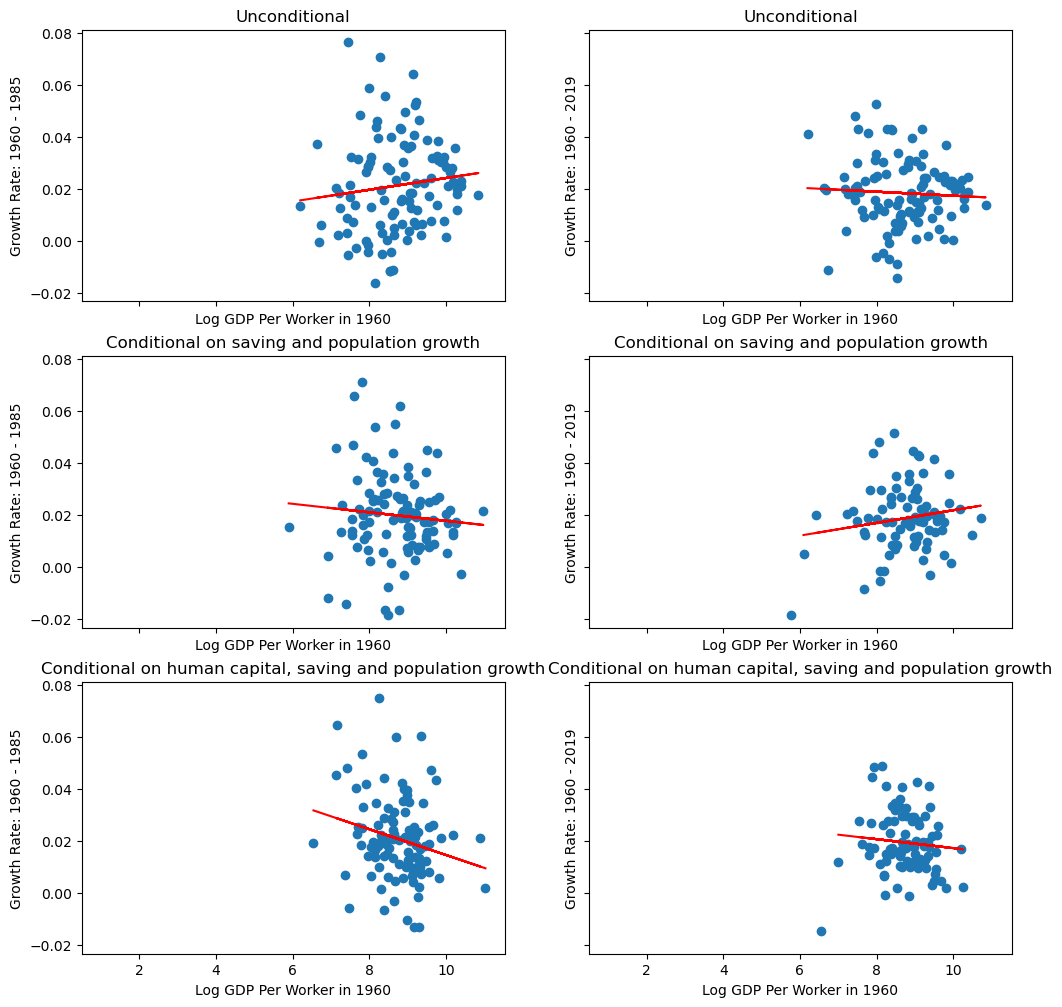

In [44]:
fig, ax = plt.subplots(3, 2, sharex = 'all',sharey='all', figsize = (12, 12))
ax[0,0].scatter(rep_data['lgdp60'], rep_data['avg_gdpg'])
ax[0,0].plot(x1, abline1, color='red')
ax[0,0].set_xlabel('Log GDP Per Worker in 1960')
ax[0,0].set_ylabel('Growth Rate: 1960 - 1985')
ax[0,0].set_title('Unconditional')


ax[1,0].scatter((rep_data['lgdp60_partialb']), 
           (rep_data['avg_gdpg_partialb']))
ax[1,0].plot(x2, abline2, color='red')
ax[1,0].set_xlabel('Log GDP Per Worker in 1960')
ax[1,0].set_ylabel('Growth Rate: 1960 - 1985')
ax[1,0].set_title('Conditional on saving and population growth')


ax[2,0].scatter(rep_data['lgdp60_partialc'], 
           rep_data['avg_gdpg_partialc'])
ax[2,0].plot(x3,abline3,color='red')
ax[2,0].set_xlabel('Log GDP Per Worker in 1960')
ax[2,0].set_ylabel('Growth Rate: 1960 - 1985')
ax[2,0].set_title('Conditional on human capital, saving and population growth')

ax[0,1].scatter(ext_data['lgdp60'], ext_data['avg_gdpg'])
ax[0,1].plot(x4, abline4, color='red')
ax[0,1].set_xlabel('Log GDP Per Worker in 1960')
ax[0,1].set_ylabel('Growth Rate: 1960 - 2019')
ax[0,1].set_title('Unconditional')


ax[1,1].scatter((ext_data['lgdp60_partialb']), 
           (ext_data['avg_gdpg_partialb']))
ax[1,1].plot(x5, abline5, color='red')
ax[1,1].set_xlabel('Log GDP Per Worker in 1960')
ax[1,1].set_ylabel('Growth Rate: 1960 - 2019')
ax[1,1].set_title('Conditional on saving and population growth')


ax[2,1].scatter(ext_data['lgdp60_partialc'], 
           ext_data['avg_gdpg_partialc'])
ax[2,1].plot(x6, abline6, color='red')
ax[2,1].set_xlabel('Log GDP Per Worker in 1960')
ax[2,1].set_ylabel('Growth Rate: 1960 - 2019')
ax[2,1].set_title('Conditional on human capital, saving and population growth')
plt.show()

Remark: See the third row. In the extension dataset(right panel), the effect of the intial level of GDP per worker on average GDP grwoth rate is slighter.

## Part III: Descriptive Statistics

In [45]:
desc_rep=rep_data.iloc[:,4:15].describe().T
desc_rep

,count,mean,std,min,25%,50%,75%,max
lgdp60,110.0,8.738803,0.976268,6.199032,8.018415,8.821419,9.426836,10.849015
lgdp85,153.0,9.316108,1.160448,6.482958,8.458778,9.364663,10.145965,12.084602
lgdpdiff,110.0,0.485893,0.449191,-0.474365,0.158150,0.443901,0.759353,1.794624
avg_popg,179.0,0.023337,0.015531,-0.006051,0.013918,0.023257,0.029935,0.111053
ls,153.0,-1.430703,0.585056,-2.957822,-1.782338,-1.319503,-1.048667,-0.169087
hc,128.0,1.728347,0.576408,1.010960,1.226156,1.594067,2.095492,3.206118
lschool,128.0,0.495602,0.318028,0.010900,0.203884,0.466289,0.739786,1.165061
lngd,179.0,-2.630969,0.184745,-3.124734,-2.750150,-2.613786,-2.526547,-1.826021
ls-lngd,152.0,1.186548,0.625744,-0.667419,0.709744,1.299714,1.682802,2.530167
lschool-lngd,128.0,3.109907,0.423503,2.310446,2.783323,2.986510,3.461732,4.012393


In [46]:
desc_ext=ext_data.iloc[:,4:17].describe().T
desc_ext

,count,mean,std,min,25%,50%,75%,max
lgdp60,110.0,8.738803,0.976268,6.199032,8.018415,8.821419,9.426836,10.849015
lgdp19,180.0,9.875305,1.106038,5.889035,9.129662,9.913929,10.699803,11.896160
lgdpdiff,110.0,0.996155,0.758700,-0.946878,0.544735,0.998977,1.396110,2.981965
avg_popg,180.0,0.020751,0.013412,-0.002707,0.010430,0.022391,0.027782,0.086327
avg_tfpg,117.0,0.004174,0.013739,-0.042701,-0.001782,0.003585,0.009297,0.065329
avg_delta,177.0,0.042994,0.011109,0.017728,0.035891,0.041107,0.047637,0.091254
ls,177.0,-1.341856,0.423534,-2.648610,-1.580383,-1.303636,-1.044860,-0.320368
hc,144.0,2.163686,0.670741,1.070629,1.568042,2.084171,2.721853,3.532727
lschool,144.0,0.722175,0.320376,0.068247,0.449798,0.734354,1.001304,1.262070
lngd,117.0,-2.754142,0.246243,-3.323477,-2.923290,-2.708447,-2.606744,-2.147607


## Part IV: Conclusion

In summary, there are two main differences in this replication project from the orginal paper. One is the coefficient on `lngd` and the other is the implied $\alpha$, $\beta$. Actually, these two are related. My guess on possible reasons for this are:
- As we saw in Table III and V, `lngd` flipped sign especially in the extension dataset, where I used a different way to construct `lngd`. In stead of assuming g+d=0.05, I applied the real data. This may cause the difference.
- Since I used an alternative way to construct `ls`, the coefficient on it may vary and further affect the coefficient on `ls-lngd` as well as the implied $\alpha$, $\beta$. 
- There are some obseavations drop in both replication and extension dataset. This may also affect the results. However, I think this reason is less likely because the drop on observations is not serious.